# **Variational Auto-Encoders (VAEs) and the Evidence Lower-BOund (ELBO)**

### This practical



*   provides skeleton code for a VAE – you are tasked with filling in the missing bits and pieces
*   has a couple of experiments to visualize interesting/useful aspects of the VAE
*   is implemented using the python library [JAX](https://jax.readthedocs.io/en/latest/index.html)
*   will give a conceptual, rather than technical, introduction to the ELBO and variants thereof





### Before getting started, let us recap the VAE.

#### Background

VAE was simultaneously proposed by [Diederik P. Kingma and Max Welling](https://arxiv.org/abs/1312.6114) [1] and [Danilo Jimenez Rezende, Shakir Mohamed and Daan Wierstra](https://arxiv.org/abs/1401.4082) [2] independently. The former was published slightly prior to the latter, and has recieved considerably more citations. If you have not yet read/looked at either, I recommend checking out [1], as it will help you in this practical (and, of course, since it is a great piece of work).

Essentially, a VAE can be seen as a mapping from an input space to a latent (hidden or unobserved) space, then from the latent space to an output space. It consists of two parts, called encoder and decoder. With the help of encoder, we can map a given input sample $x_{ori} \sim p(x)$ to a distribution over the latent space. The distribution is denoted by $q_{\phi}(z|x_{ori})$ and $\phi$ denotes the parameters of the encoder (optimized via training), called ([variational](https://www.cs.jhu.edu/~jason/tutorials/variational.html)) parameters.

In mathematics, finding the best function (the distribution over the latent space in our case, i.e. $q_{\phi}(z|x_{ori})$) is done under the name of calculus of variations and this name also comes from that mathematical background. Variational approximation, (finding the best or closest function to a given function, in our case the true distribution over the latent sapce $p(z|x_{ori})$) is usually done because of the complexity of the original function (it means, it is hard to work with $p(z|x_{ori})$ because it has interactable terms).

So the idea of variational approximation is that to fix a family of distributions, say $Q$ (think of it as the set of all possible normal distributions $Q=\{\mathcal{N}(\mu,\sigma)| \mu \in \mathbb{R}, \sigma \in \mathbb{R}^+\}$), and then approximate a complex function, needless to say $p(z|x_{ori})$, with a simpler function $q_\phi(z|x_{ori}) \in Q$. To this end, we need to find the closest $q_\phi(z|x_{ori})$ to $p(z|x_{ori})$, and the parameters of $q_\phi(z|x_{ori})$ (in our example, a good $\mu$ and $\sigma$) are called **variational parameters**. The subscript $\phi$, also called variational paramters or encoder paramters, denotes that the distribution we get, depends on some other variables that has to be optimized (i.e. the variables that we use to map a given input $x$ to a distribution over the latent space, for example $\phi=\{W_1,W_2,b_1,b_2\}$ if we are using a two layer MLP).

Note that $q_\phi(z|x)$ is a function of two variables both $x$ and $z$ and when you plug in some specific $x$, you still have a function of $z$.  Therefore, $q_\phi(z|x)$ gives us the paramters of a distribution (in our example it gives us some specific $\mu$ and $\sigma$ after plugging it $x$). Then, after getting the paramters of a distribution over the latent space $q_\phi(z|x_{ori})$, it is time to reconstruct the input sample $x_{ori}$ from its latent representation $q_\phi(z|x_{ori})$, but the problem is that we can not use a function as input into the decoder! So what we can do is to draw (several) samples from the latent distribution $q_\phi(z|x_{ori})$ and recover a distribution over the  input space. Another the problem is that it is that, sampling is not differentiable, making our model indifferentiable. To see why, try to diffrentiate a sample drawn from a Normal distribution, i.e. while $x \sim \mathcal{N}(\mu,\sigma)$ try to compute the following:
$$
\frac{dx}{d\mu}
$$

To solve the problem regarding the sampling and indifferentiability, [1] have proposed a trick called **reparameterization trick**, of which you'll hear more in the rest of this practical. But for now, it suffices to assume that we know we can use a sample like $z_{ori} \sim q_\phi(z|x_{ori})$, to map it back to the input sapce again, using a decoder, or so called **the generative** model. In our example, it is as simple as $z_{ori} \sim \mathcal{N}(\mu_{ori},\sigma_{ori})$ where the $\mu_{ori}$ and $\sigma_{ori}$ is obtained simply by plugging in $x_{ori}$ into the encoder, i.e. $q_\phi(z|x_{ori})$.

As the decoder is acting on samples of a distribution, and becomes stochastic by virtue of sampling, it defines a distribution over the input space. Therefore, the **distribution recovered** from $z_{ori}$ by the decoder, is denoted by $p_\theta(x|z_{ori})$.

The $\theta$ subscript is the parameters of the generative model, also called generative paramters are optimized jointly with $\phi$. Finally, we can *decode* $z_{ori}$ by sampling from $p_{\theta}(x|z_{ori})$. The decoding of $z_{ori}$, i.e. $x_{rec}\sim p_{\theta}(x|z_{ori})$, is commonly referred to as the *reconstruction*.

Note that in the original paper you do not see any distinction between $x_{ori}$, $x_{rec}$ and $x$ as they are in the same space, but it is added here to make it easy to explain the idea! Following [1], we avoid the use of subscripts in the rest of the practical.

### Why?
There are plenty of interesting tasks that can be tackled using VAEs. Some important examples include dimensionality reduction (encoding $x$ as $z$, such that dim($z$) < dim($x$)), noise filtering (a.k.a. reconstructing the input), generating synthetic data (sampling from $p_{\theta}(x|z)$) and density estimation. Let us zoom in on the latter.

Say we are interested in learning the posterior distribution $p(z|x)$ for whatever reason. In most interesting scenarios, however, we cannot learn it since it is intractable. The intractability of

$$
  p(z|x) = \frac{p(z,x)}{p(x)}
$$

stems from not being able to compute $p(x) = \int p(z, x) dz$ as it involves marginalizing over all $z$. Instead of learning $p(z|x)$ directly, we have to approximate it.



### How?
The VAE is a form of (amortized) variational inference (VI). In VI we approximate the intractable posterior using a simpler distribution, $q_{\phi}(z|x)$, inferring $\phi$ by estimating the marginal log-likelihood, $\log p(x)$. Consequently, we actually estimate two densities.

The inference is performed by *maximizing* the **E**vidence **L**ower **BO**ound (ELBO in short), $\mathcal{L}$:

$$\mathbb{E}_{q_{\phi}(z|x)}\left[\log\frac{p(z, x)}{q_{\phi}(z|x)}\right] \triangleq \mathcal{L} = - D_{KL}(q_{\phi}(z|x)||p(z)) +\mathbb{E}_{q_{\phi}(z|x)}\left[\log p_\theta(x|z)\right]$$

where $D_{KL}(q_{\phi}(z|x)||p(z))$ is the Kullback-Leibler (KL) divergence. The KL divergence is strictly non-negative, and zero if and only if $q_{\phi}(z|x) = p(z)$, while the marginal log-likelihood, $\log p(x)$, is a constant. It is also possible to write:

$$\log p(x) = D_{KL}(q_{\phi}(z|x)||p(z|x)) + \mathcal{L}$$
The $D_{KL}(q_{\phi}(z|x)||p(z|x))$ term is called **the variational gap** and is non-negative, so it can be seen that we have:
$$\log p(x) \geq \mathcal{L}$$

Therefore, the ELBO is a lower bound on the marginal log-likelihood and maximizing $\mathcal{L}$ indirectly minimizes $D_{KL}(q_{\phi}(z|x)||p(z|x))$ (which we do not have), giving us a better approximation of the intractable posterior.  See [1] for the derivation.
Note that the negated ELBO is often referred to as the negative log-likelihood (NLL).

In this practical, as in [1], we will assume that $q_\phi(z|x) = \mathcal{N}(z;\mu,\sigma^2)$, $p(z)=\mathcal{N}(0,1)$ and $p_{\theta}(x|z) = \text{Bernoulli}(x;θ$). Hence we can evaluate all terms in the ELBO, where $p(z,x) = p_\theta(x|z)p(z)$.

### Benchmarking VAEs in Density Estimation Tasks
This will be a recurring topic in this practical. Namely, you may train on whichever objective function you deem fitting, however when reporting your results in order to compare the performance of your algorithm, the evaluation of the **correct** objective is crucial. For instance, if you want to compare your VAE's NLL scores with others', then make sure the objective function is in fact a lower-bound on the marginal log-likelihood. More on that later.

## VAE in JAX
Now, let's import the necessary libraries. Feel free to add imports as you wish.

In [1]:
import os
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp
import jax
import jax.numpy as jnp
from jax import jit, grad, lax, random
from jax.example_libraries import optimizers
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, FanOut, Relu, Softplus, Sigmoid
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST, FashionMNIST
from functools import partial
from jax import config
config.update("jax_enable_x64",True)

# IMPORTANT NOTE:
# if you have got a NaN loss and/or have trouble debugging. Then, set
# jax_disable_jit to True. This will help you print out the variables.
jax.config.update('jax_disable_jit', False)

For the sake of simplicity, we use the MNIST dataset in this practical.

The next cell creates a PyTorch dataloader. Using either PyTorch or TensorFlow dataloaders seems to (currently) be the practice when working with JAX. The code has been slighlty altered after being copying from [here](https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/Neural_Network_and_Data_Loading.ipynb#scrollTo=94PjXZ8y3dVF).

In [2]:
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [3]:
batch_size = 248
# Define our dataset, using torch datasets
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = jnp.array(mnist_dataset_test.test_labels)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 16679308.32it/s]


Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 490646.42it/s]


Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 3948242.39it/s]


Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 9252320.92it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### Initializing the Network and Optimizer

Next we put together a simple VAE, using two-layered MLPs with 300 hidden units for both the encoder and decoder networks. Note that the two parallel ultimate layers in the encoder net output latent_dimensions-dimensional arrays. **Based on the respective ranges of these two outputs, which one is $\mu$ and which is $\sigma$?**

Also, note that we apply **the sigmoid function on the outputs of the decoder**. Recall that $p_\theta(x|z)$ models the paramters of a Bernoulli distribution.

Initialize the networks and the Adam optimizer.

In [4]:
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.001)
opt_state = opt_init(params)

### Task 1: Reparameterization Trick
See [1] to figure out what **reparameterization trick** is, and implement the reparameterization trick in the following function.

In [5]:
def sample(rng, mu, std):
  # use the reparameterization trick
  # sample episilon~N(0,1)
  epsilon = random.normal(rng, mu.shape)
  z = mu + std * epsilon
  return z

Continuing with the VAE pipeline. "@jit" is a JAX decoration which apparently heavily speeds up operations. Beware, however, that it does not support all operations, putting restrictions on the function it decorates.

In [6]:
@jit
def forward(params, x, rng):
    encoder_params, decoder_params = params
    phi = encode(encoder_params, inputs=x)
    z = sample(rng, mu=phi[0], std=phi[1])
    bernoulli_theta = decode(decoder_params, z)
    return phi, z, bernoulli_theta

### Task 2: ELBO
**Compute the ELBO in the following function.** Feel free to add or remove input arguments, except for params; params should be the first input argument (it's due to how JAX computes gradients). Also, since the optimizer *minimizes* the objective function, make sure to return the negated ELBO. Hint: recall the definition of the ELBO, note that it can be Monte Carlo approximated as follows

$\mathcal{L} = \mathbb{E}_{q_\phi(z|x)}\left[ \log\frac{p_\theta(x|z)p(z)}{q_\phi(z|x)} \right] \simeq \frac{1}{L}\sum_l \log\frac{p_\theta(x|z_l)p(z_l)}{q_\phi(z_l|x)}$,

and, following [1], let $L=1$.

Finally, package `tfp.distributions` could be used to calculate the (log) probability of different distributions. For instance, we could use `tfp.distributions.Bernoulli` to compute the likelihood of the pixels.

In [7]:
@jit
def get_elbo(params, x, rng):
    # the negative elbo should be a scalar value, i.e. averaged over the mini-batch.
    (mu,sigma), z, bernoulli_theta = forward(params, x, rng)
    log_px_z = tfp.distributions.Bernoulli(probs=bernoulli_theta).log_prob(x).sum(axis=-1) # log p_theta(x|z)
    kl_divergence =-0.5 * jnp.sum(1 + jnp.log(jnp.square(sigma)) - jnp.square(mu) - jnp.square(sigma), axis=-1)
    elbo = jnp.mean(log_px_z - kl_divergence)

    return -elbo

Now to the training and evaluation steps. Note that we have normalized the pixel values in order for them to fit the probabilistic model.

In [8]:
def epoch_step(epoch, training_generator, opt_state):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) / 255.0

        value, grads = jax.value_and_grad(get_elbo)(get_params(opt_state), x, rng)
        opt_state = opt_update(i, grads, opt_state)

        nlls.append(value)
    return opt_state, np.mean(nlls)

Luckily, the complete test set fits in the memory, and so we can compute the average NLL on all images at once without taking the batch size into account. This might not always be possible, in which case you must be careful regarding how you average the NLL scores, since all batches needn't be of the same size. Failing to do so will make your NLL scores unfit for benchmarking.

In [9]:
def evaluate(opt_state, x, test_rng):
    params = get_params(opt_state)
    x = jax.device_put(x) / 255.0
    nll = get_elbo(params, x, test_rng)
    return nll

**Plot the NLL vs. epochs curves (train and test) and see that they're decaying.**

Epoch:  0


100%|██████████| 242/242 [00:36<00:00,  6.62it/s]


Train NLL: 205.6265869140625
Test NLL:  178.09772 

Epoch:  1


100%|██████████| 242/242 [00:15<00:00, 15.87it/s]


Train NLL: 173.98731994628906
Test NLL:  172.73009 

Epoch:  2


100%|██████████| 242/242 [00:17<00:00, 13.86it/s]


Train NLL: 169.52389526367188
Test NLL:  169.15182 

Epoch:  3


100%|██████████| 242/242 [00:15<00:00, 15.61it/s]


Train NLL: 166.0775146484375
Test NLL:  165.70517 

Epoch:  4


100%|██████████| 242/242 [00:15<00:00, 16.06it/s]


Train NLL: 163.55055236816406
Test NLL:  163.83571 

Epoch:  5


100%|██████████| 242/242 [00:15<00:00, 15.96it/s]


Train NLL: 161.65731811523438
Test NLL:  161.95473 

Epoch:  6


100%|██████████| 242/242 [00:15<00:00, 15.55it/s]


Train NLL: 159.96449279785156
Test NLL:  160.4258 

Epoch:  7


100%|██████████| 242/242 [00:16<00:00, 14.83it/s]


Train NLL: 158.4846649169922
Test NLL:  159.46614 

Epoch:  8


100%|██████████| 242/242 [00:15<00:00, 15.82it/s]


Train NLL: 157.330078125
Test NLL:  158.42262 

Epoch:  9


100%|██████████| 242/242 [00:15<00:00, 15.66it/s]


Train NLL: 156.23529052734375
Test NLL:  157.70387 

Epoch:  10


100%|██████████| 242/242 [00:15<00:00, 15.75it/s]


Train NLL: 155.40023803710938
Test NLL:  156.76833 

Epoch:  11


100%|██████████| 242/242 [00:15<00:00, 15.53it/s]


Train NLL: 154.62612915039062
Test NLL:  155.89621 

Epoch:  12


100%|██████████| 242/242 [00:30<00:00,  7.98it/s]


Train NLL: 153.95188903808594
Test NLL:  155.38487 

Epoch:  13


100%|██████████| 242/242 [00:19<00:00, 12.59it/s]


Train NLL: 153.32470703125
Test NLL:  154.98245 

Epoch:  14


100%|██████████| 242/242 [00:21<00:00, 11.04it/s]


Train NLL: 152.58193969726562
Test NLL:  154.23726 

Epoch:  15


100%|██████████| 242/242 [00:15<00:00, 15.92it/s]


Train NLL: 152.1094970703125
Test NLL:  153.77945 

Epoch:  16


100%|██████████| 242/242 [00:16<00:00, 14.93it/s]


Train NLL: 151.50115966796875
Test NLL:  153.09901 

Epoch:  17


100%|██████████| 242/242 [00:20<00:00, 11.98it/s]


Train NLL: 151.06967163085938
Test NLL:  152.71939 

Epoch:  18


100%|██████████| 242/242 [00:15<00:00, 15.44it/s]


Train NLL: 150.5438690185547
Test NLL:  152.28525 

Epoch:  19


100%|██████████| 242/242 [00:15<00:00, 15.20it/s]


Train NLL: 150.2017059326172
Test NLL:  152.22784 



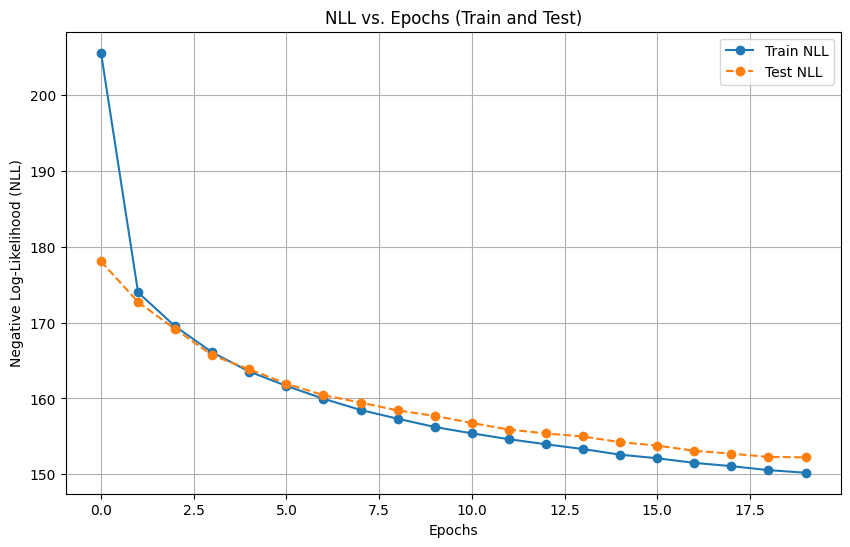

In [ ]:
n_epochs = 20
test_key = random.PRNGKey(10)

nll_train_list = []
nll_test_list = []

for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    opt_state, nll_train = epoch_step(epoch, training_generator, opt_state)
    nll_train_list.append(nll_train)
    nll_test = evaluate(opt_state, test_images, test_key)
    nll_test_list.append(nll_test)
    print(f"Train NLL: {nll_train}")
    print("Test NLL: ", nll_test, '\n')

# Plotting NLL vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(n_epochs), nll_train_list, label='Train NLL', marker='o')
plt.plot(range(n_epochs), nll_test_list, label='Test NLL', marker='o', linestyle='--')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Negative Log-Likelihood (NLL)')
plt.title('NLL vs. Epochs (Train and Test)')
plt.legend()
plt.grid()
plt.show()

### Task 3: Experiments

Let's put the trained VAE to use by visulizing the latent space and sampling synthetic data. Complete the following code snippets to do so.
**Visualize the latent space. Use the labels $y$ to color the latent representations in a scatter plot.**

Hint: Encode the training or test set, and use `plt.scatter`.

In [ ]:
def show_latent_space():
  encoder_params = get_params(opt_state)[0]
  (mu, sigma), z, bernoulli_theta = forward((encoder_params, []), test_images, test_key)
  labels = test_labels
  # Scatter plot of the latent representations
  plt.figure(figsize=(10, 8))
  plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='viridis', alpha=0.5)  # Use the labels for coloring
  plt.colorbar(label='Labels')
  plt.xlabel('Latent Dimension 1')
  plt.ylabel('Latent Dimension 2')
  plt.title('Latent Space Visualization')
  plt.grid(True)
  plt.show()
  pass

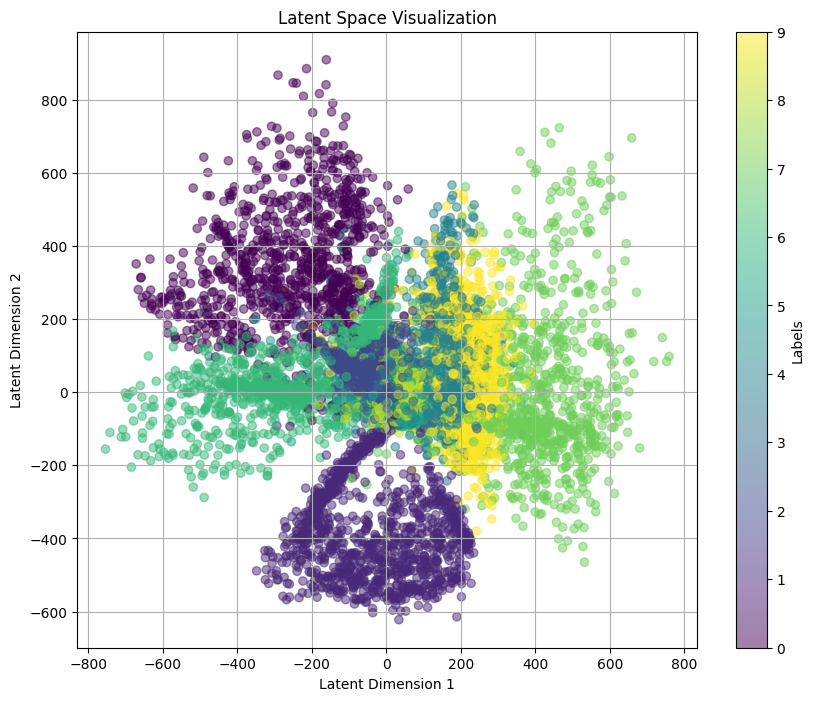

In [ ]:
show_latent_space()

Monitor the reconstruction quality of your model. Visualize a single input image together its reconstruction.

In [ ]:
def reconstruct_an_image():
  # reconstruct_an_image()
  x = test_images[10]  # the image to be reconstructed
  opt_params = get_params(opt_state)
  # call the forwad function and use its output to reconstruct the image
  (mu, sigma), z, bernoulli_theta = forward(opt_params, x, random.PRNGKey(10))
  z_sampled = sample(random.PRNGKey(10), mu, sigma)
  decoded_image = decode(opt_params[1], z_sampled)

  plt.figure(figsize=(8, 4))
  plt.subplot(1, 2, 1)
  plt.imshow(x.reshape(28, 28), cmap='gray')
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(decoded_image.reshape(28, 28), cmap='gray')
  plt.title('Reconstructed Image')
  plt.axis('off')

  plt.show()

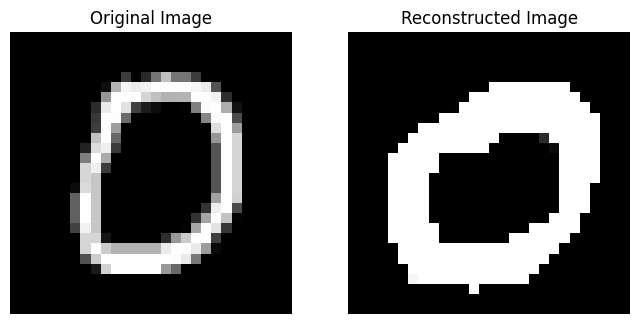

In [ ]:
reconstruct_an_image()

**Generate synthetic data.** Hint: sample $z\sim p(z)$ or "walk" in the latent space. Decode the $z$ you sample/visit and plot the decoded image. Think about what output you expect when you sample from 1) a Bernoulli distribution, or 2) regard the Bernoulli parameter as the sample.

In [ ]:
def plot_grid(decoder_params, grid_size=5, latent_dim=2, range_val=2.0):

    # Create a grid of z values between -range_val and +range_val
    z_vals = np.linspace(-range_val, range_val, grid_size)

    # Initialize an empty list to hold the decoded images
    images = []
    for z1 in z_vals:
        row_images = []
        for z2 in z_vals:
            z = jnp.array([z1, z2])
            sampled_image = decode(opt_params[1], z)
            row_images.append(sampled_image.reshape(28, 28))
        images.append(row_images)

    fig, axs = plt.subplots(len(images), len(images[0]), figsize=(10, 10))

    for i, row in enumerate(images):
        for j, image in enumerate(row):
            axs[i, j].imshow(image, cmap='gray')
            axs[i, j].axis('off')

    plt.show()

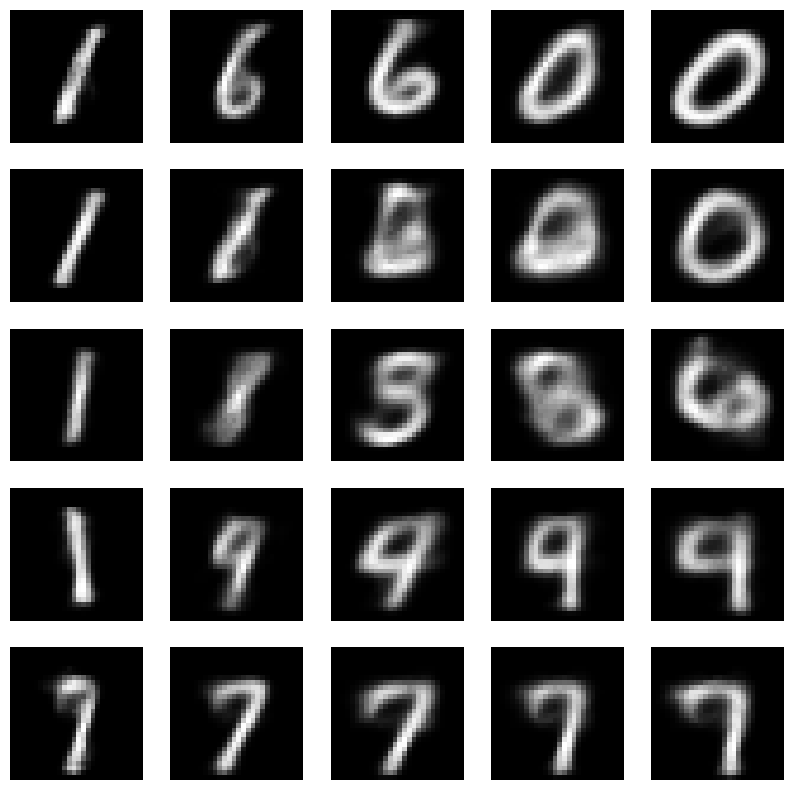

In [ ]:
opt_params=get_params(opt_state)

plot_grid(opt_params[1])

## $\beta$-VAE

The $\beta$-VAE was proposed by [Higgins et al.](https://openreview.net/pdf?id=Sy2fzU9gl) in 2017 and is a straightforward but important extension of the VAE. In terms of architecture, $\beta$-VAE and VAE are indistinguishable. In fact, the novelty in the work by Higgins et al. lies in a minor modification of the ELBO objective, the $\beta$-objective

$\mathcal{L}_\beta = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - \beta \mathbb{E}_{q_\phi(z|x)}[\log \frac{q_\phi(z|x)}{p(z)}]$,

where $\beta\geq0$ is a hyperparameter weighting the KL divergence

KL$(q_\phi(z|x)\Vert p(z)) = \mathbb{E}_{q_\phi(z|x)}[\log \frac{q_\phi(z|x)}{p(z)}]$. Observe that we retrieve the standard ELBO when $\beta=1$.

This objective is useful for

* emphasizing high-fidelity reconstructions *or* disentangling the latent space
* obtaining an increased interpretability
* doing KL warm-up.

The effects of the $\beta$-objective are mostly visible asymptotically, why we may not experience the full power of it here (e.g., [NVAE](https://arxiv.org/pdf/2007.03898.pdf) applies KL warm-up during the *first 25k iterations*).

However, plenty of the state-of-the-art VAEs (in terms of density estimation) apply KL warm-up (e.g. NVAE, [VampPrior](https://arxiv.org/pdf/1705.07120.pdf), [LadderVAE](https://arxiv.org/pdf/1602.02282.pdf); see LadderVAE for a nice motivation of KL warm-up), so it is good to know. Also, aside from being very straightforward to implement, the $\beta$-objective leads us to the following important note.

**Important note**: as pointed out by [Hoffman et al.](http://bayesiandeeplearning.org/2017/papers/66.pdf), the $\beta$-objective shown above cannot be considered an evidence lower-bound. Hence, test scores based on the $\beta$-objective **should not be used for benchmarking against proper marginal log-likelihood estimates (such as the ELBO)**. If you are interested, try to reverse the derivations of the ELBO in [1] while including $\beta$.

### Task 4: $\beta$-ELBO

**Compute the $\beta$-objective in the following function.**

Hint: this should require minimal changes to the ```get_elbo```
function above. Also, observe that



$\mathcal{L}_\beta \simeq \frac{1}{L}\sum_l \log p_\theta(x|z_l)-\beta\log\frac{q_\phi(z_l|x)}{p(z_l)}$.


In [ ]:
@jit
def get_beta_elbo(params, x, rng, beta):
    # the negative elbo should be a scalar value, i.e. averaged over the mini-batch.
    (mu, sigma), z, bernoulli_theta = forward(params, x, rng)
    # write code to compute the ELBO
    log_px_z = tfp.distributions.Bernoulli(probs=bernoulli_theta).log_prob(x).sum(axis=-1) # log p_theta(x|z)
    kl_divergence =-0.5 * beta * jnp.sum(1 + jnp.log(jnp.square(sigma)) - jnp.square(mu) - jnp.square(sigma), axis=-1)
    beta_elbo = jnp.mean(log_px_z - kl_divergence)
    return -beta_elbo

Now we define ```epoch_step_beta``` that calls ```get_beta_elbo``` instead of ```get_elbo```, and so that it can take a $\beta\geq 0$ as input.

In [ ]:
def epoch_step_beta(epoch, training_generator, opt_state, beta):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) / 255
        value, grads = jax.value_and_grad(get_beta_elbo)(get_params(opt_state),
                                                         x,
                                                         rng,
                                                         beta)
        opt_state = opt_update(i,
                               grads,
                               opt_state)
        nlls.append(value)
    return opt_state, np.mean(nlls)

Again, importantly, we have used $\beta=1$ as default in ```evaluate_beta```, which makes the evaluation scores comparable to those of the standard VAE that we trained above.

In [ ]:
def evaluate_beta(opt_state, x, test_rng,beta=1):
    params = get_params(opt_state)
    x = jax.device_put(x) / 255
    nll = get_beta_elbo(params,
                        x,
                        test_rng,beta)
    return nll

Before retraining the VAE, or $\beta$-VAE, we need to reinitialize the encoder/decoder nets and the optimizer above. This is done by simply running the cell below.

In [ ]:
beta = 5  # just an example for a big beta. Try with other values!
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.001)
opt_state = opt_init(params)

Rerun the experiments section below. Any difference? If you train for a few couple of epochs, then we shouldn't expect huge variations. But perhaps setting $\beta$ to something very big will affect the distribution of $z$'s in the latent space? Does setting $\beta=0$ affect the fidelity of the reconstructed image? Why would we, at least asymptotically, expect these effects?

If the $\beta$ is too large, it encourages z to conform more strictly to the prior, leading to less diverse and less accurate reconstructions. Setting $\beta=0$ will remove the KL term, and z is no longer constrained to match the prior distribution. It will improve reconstruction fidelity at the cost of not having a well-structured or interpretable latent space, which affects generalization. We may expect the $\beta$ to be zero to perfectly fit and construct training data, and $\beta$ to be large so that the posterior will match the prior.

### Task 4: $\beta$-Experiments

In [ ]:
n_epochs = 20
train_key,test_key = random.split(random.PRNGKey(10))
for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    opt_state, nll_train = epoch_step_beta(epoch,
                                           training_generator,
                                           opt_state,
                                           beta)
    nll_test = evaluate_beta(opt_state,
                             test_images,
                             test_key)
    print("Train NLL: ", nll_train)
    print("Test NLL: ", nll_test)

Epoch:  0


100%|██████████| 242/242 [00:19<00:00, 12.35it/s]


Train NLL:  219.02608
Test NLL:  186.03543
Epoch:  1


100%|██████████| 242/242 [00:16<00:00, 14.83it/s]


Train NLL:  190.0706
Test NLL:  181.32417
Epoch:  2


100%|██████████| 242/242 [00:16<00:00, 14.73it/s]


Train NLL:  187.91106
Test NLL:  179.29407
Epoch:  3


100%|██████████| 242/242 [00:17<00:00, 13.65it/s]


Train NLL:  186.17085
Test NLL:  177.19183
Epoch:  4


100%|██████████| 242/242 [00:16<00:00, 14.84it/s]


Train NLL:  184.59024
Test NLL:  174.5694
Epoch:  5


100%|██████████| 242/242 [00:16<00:00, 14.69it/s]


Train NLL:  183.10318
Test NLL:  172.75699
Epoch:  6


100%|██████████| 242/242 [00:16<00:00, 14.36it/s]


Train NLL:  181.67378
Test NLL:  170.28537
Epoch:  7


100%|██████████| 242/242 [00:17<00:00, 14.13it/s]


Train NLL:  179.84279
Test NLL:  168.98575
Epoch:  8


100%|██████████| 242/242 [00:16<00:00, 14.70it/s]


Train NLL:  178.88449
Test NLL:  167.38766
Epoch:  9


100%|██████████| 242/242 [00:16<00:00, 14.73it/s]


Train NLL:  177.61101
Test NLL:  166.17729
Epoch:  10


100%|██████████| 242/242 [00:17<00:00, 13.77it/s]


Train NLL:  176.8377
Test NLL:  166.09142
Epoch:  11


100%|██████████| 242/242 [00:16<00:00, 14.62it/s]


Train NLL:  176.04158
Test NLL:  164.7556
Epoch:  12


100%|██████████| 242/242 [00:16<00:00, 14.83it/s]


Train NLL:  175.78131
Test NLL:  163.2002
Epoch:  13


100%|██████████| 242/242 [00:16<00:00, 14.73it/s]


Train NLL:  175.42216
Test NLL:  162.74088
Epoch:  14


100%|██████████| 242/242 [00:19<00:00, 12.25it/s]


Train NLL:  174.35664
Test NLL:  162.9661
Epoch:  15


100%|██████████| 242/242 [00:16<00:00, 14.36it/s]


Train NLL:  174.3605
Test NLL:  161.82454
Epoch:  16


100%|██████████| 242/242 [00:16<00:00, 14.49it/s]


Train NLL:  173.48434
Test NLL:  161.80283
Epoch:  17


100%|██████████| 242/242 [00:17<00:00, 13.50it/s]


Train NLL:  173.4755
Test NLL:  160.67975
Epoch:  18


100%|██████████| 242/242 [00:16<00:00, 14.41it/s]


Train NLL:  172.9979
Test NLL:  160.07202
Epoch:  19


100%|██████████| 242/242 [00:16<00:00, 14.65it/s]


Train NLL:  173.07262
Test NLL:  159.65497


What has changed in the latent space? Try playing with a few values of $\beta$ and explain what affects the change in the latent space?

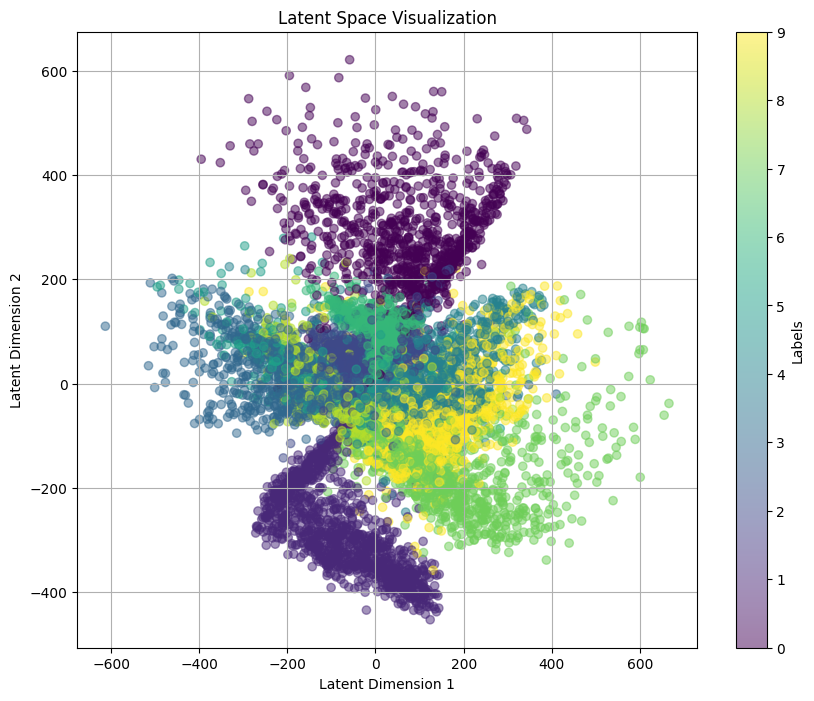

In [ ]:
# visualize the latent space
show_latent_space()

What about the reconstruction quality of your model? Has it improved or degraded?

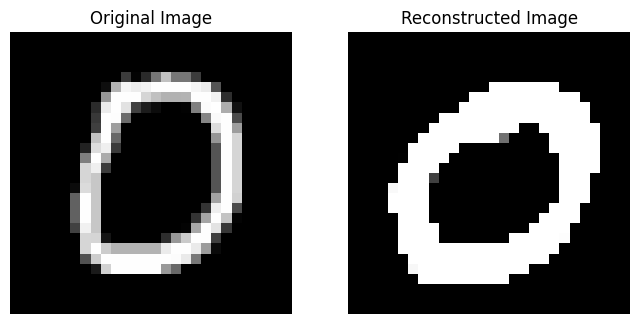

In [ ]:
# reconstruct an image
reconstruct_an_image()

Sample from the latent space and decode. Do you see any difference?

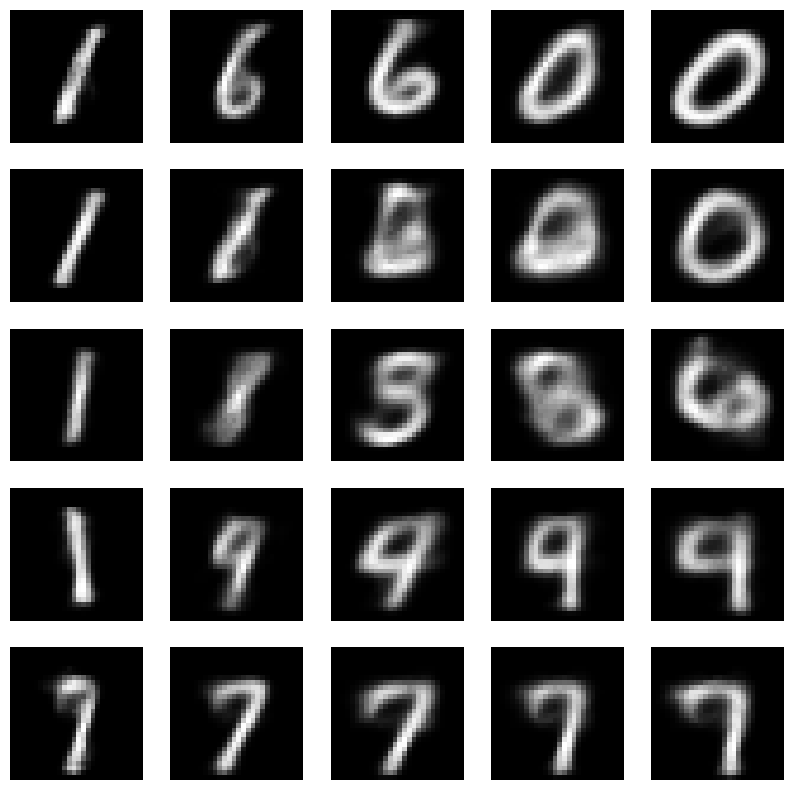

In [ ]:
# sample a few images
opt_beta_params=get_params(opt_state)
plot_grid(opt_beta_params[1])

In [ ]:
beta = 0  # just an example for a big beta. Try with other values!
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.001)
opt_state = opt_init(params)


n_epochs = 20
train_key,test_key = random.split(random.PRNGKey(10))
for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    opt_state, nll_train = epoch_step_beta(epoch,
                                           training_generator,
                                           opt_state,
                                           beta)
    nll_test = evaluate_beta(opt_state,
                             test_images,
                             test_key)
    print("Train NLL: ", nll_train)
    print("Test NLL: ", nll_test)

Epoch:  0


100%|██████████| 242/242 [00:29<00:00,  8.11it/s]


Train NLL:  203.9291238426047
Test NLL:  253.07117593788706
Epoch:  1


100%|██████████| 242/242 [00:17<00:00, 13.93it/s]


Train NLL:  171.53385110260228
Test NLL:  251.34640251943256
Epoch:  2


100%|██████████| 242/242 [00:16<00:00, 14.34it/s]


Train NLL:  164.71441746518667
Test NLL:  258.9909440036167
Epoch:  3


100%|██████████| 242/242 [00:18<00:00, 13.20it/s]


Train NLL:  159.6536100746877
Test NLL:  282.327753790919
Epoch:  4


100%|██████████| 242/242 [00:17<00:00, 13.89it/s]


Train NLL:  155.5169952681604
Test NLL:  312.46209607375044
Epoch:  5


100%|██████████| 242/242 [00:16<00:00, 14.28it/s]


Train NLL:  152.84736317371485
Test NLL:  327.8407267763681
Epoch:  6


100%|██████████| 242/242 [00:17<00:00, 13.76it/s]


Train NLL:  151.00161732497264
Test NLL:  336.6878856557498
Epoch:  7


100%|██████████| 242/242 [00:16<00:00, 14.47it/s]


Train NLL:  149.54633070758672
Test NLL:  344.7665885194023
Epoch:  8


100%|██████████| 242/242 [00:16<00:00, 14.43it/s]


Train NLL:  148.2737254462803
Test NLL:  349.3653788234114
Epoch:  9


100%|██████████| 242/242 [00:17<00:00, 13.75it/s]


Train NLL:  147.2440019774375
Test NLL:  351.83562959874
Epoch:  10


100%|██████████| 242/242 [00:16<00:00, 14.46it/s]


Train NLL:  146.2711383258745
Test NLL:  358.1847786840454
Epoch:  11


100%|██████████| 242/242 [00:17<00:00, 13.99it/s]


Train NLL:  145.41476127060636
Test NLL:  360.5446276866497
Epoch:  12


100%|██████████| 242/242 [00:17<00:00, 14.21it/s]


Train NLL:  144.67093953045284
Test NLL:  361.424116436364
Epoch:  13


100%|██████████| 242/242 [00:17<00:00, 14.15it/s]


Train NLL:  144.0126514251635
Test NLL:  365.33896577141485
Epoch:  14


100%|██████████| 242/242 [00:17<00:00, 13.87it/s]


Train NLL:  143.4203835916944
Test NLL:  366.43127057499504
Epoch:  15


100%|██████████| 242/242 [00:16<00:00, 14.46it/s]


Train NLL:  142.87558469712437
Test NLL:  366.558097800475
Epoch:  16


100%|██████████| 242/242 [00:17<00:00, 14.21it/s]


Train NLL:  142.35141612750095
Test NLL:  364.5994149549299
Epoch:  17


100%|██████████| 242/242 [00:17<00:00, 13.91it/s]


Train NLL:  141.83802181080972
Test NLL:  366.0373464941447
Epoch:  18


100%|██████████| 242/242 [00:16<00:00, 14.42it/s]


Train NLL:  141.36362381877413
Test NLL:  370.12432013760053
Epoch:  19


100%|██████████| 242/242 [00:17<00:00, 13.80it/s]


Train NLL:  140.90347118475083
Test NLL:  369.9044171318534


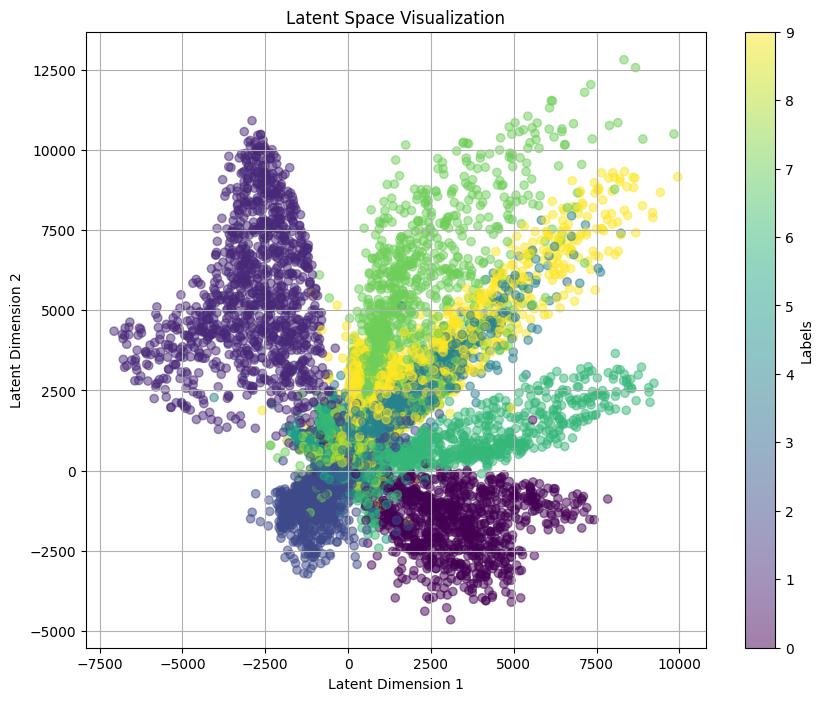

In [ ]:
show_latent_space()

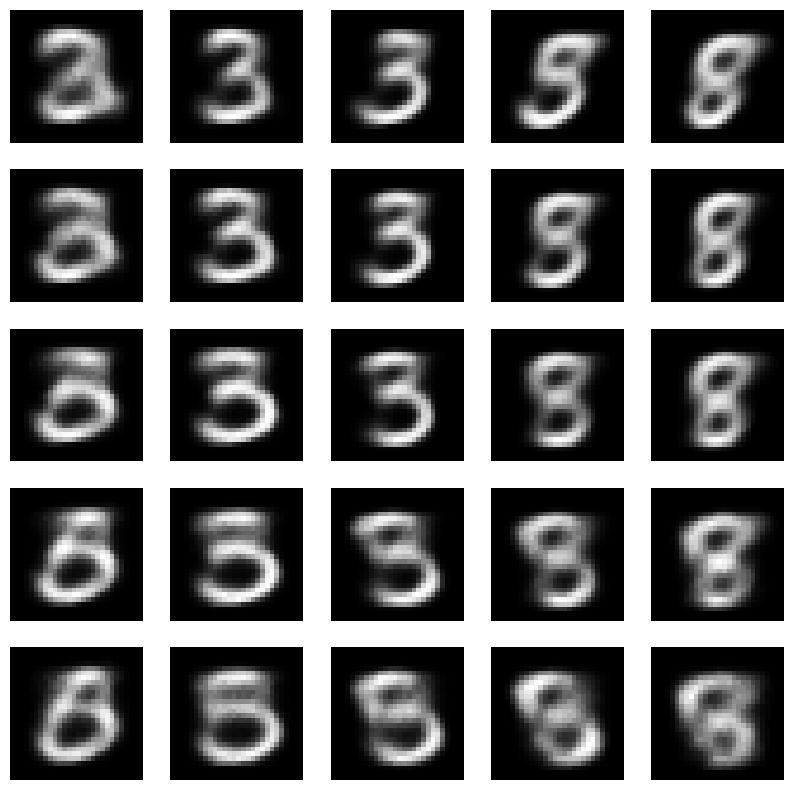

In [ ]:
opt_params=get_params(opt_state)

plot_grid(opt_params[1])

## Importance Weigthed Auto-Encoder (IWAE)


Similarily as for $\beta$-VAE, the distinguishing factor between the VAE and [IWAE](https://arxiv.org/abs/1509.00519) is the alternative objective function, the importance weighted ELBO (IWELBO):

$\mathcal{L}_{K} = \mathbb{E}_{q_\phi(z|x)}\left[\log\frac{1}{K}\sum_k\frac{p_\theta(x|z_k)p(z_k)}{q_\phi(z_k|x)}\right]$.

When computing $\mathcal{L}_{K}$ in contrast to the ELBO, we sample $K$ latent representations instead of one. Although this might seem like a simple extension, the IWELBO has huge implications on the field of VAEs, *as well as* the VI literature in general (see e.g. [Domke and Sheldon](https://arxiv.org/pdf/1808.09034.pdf)). Specifically (n.b., *not an exhaustive list*),

* it is a proper lower-bound on the marginal log-likelihood.
* it is an effective way of improving the NLL test scores (used by state-of-the-art VAEs when reporting NLL scores, including those mentioned above).

The former bullet implies that we *can* use IWELBO to benchmark our VAE against other VAEs, in contrast to the $\beta$-objective. The latter bullet implies that we probably *should* use it when benchmarking. Because, accoring to  Theorem 1 in the IWAE paper, the marginal log-likelihood estimates are montonically increasing with $K$, meaning that

$\mathcal{L}_{K}\geq \mathcal{L}_{K-1}\geq \mathcal{L}$.

### Task 5: IWELBO

Modify the following functions such that $K$ samples are drawn instead of 1. Then compute the IWELBO.

In [10]:
@partial(jax.jit, static_argnames=['K'])
def sample_K(rng, mu, std, K):
  # use the reparameterization trick and sample K latent variables rather than 1

  mu_exp = jnp.repeat(mu[:, jnp.newaxis, :], K, axis = 1)
  std_exp = jnp.repeat(std[:, jnp.newaxis, :], K, axis = 1) #(248, K, 2)
  epsilon = jax.random.normal(rng, mu_exp.shape)
  z = mu_exp + epsilon * std_exp
  print(z.shape)
  return z

In [11]:
@partial(jax.jit, static_argnames=['K'])
def forward_K(params, x, rng, K):
    encoder_params, decoder_params = params
    phi = encode(encoder_params, inputs=x)
    z = sample_K(rng,
            mu=phi[0],
            std=phi[1],
            K=K)
    bernoulli_theta = decode(decoder_params, z)
    return phi, z, bernoulli_theta

In [12]:
from jax.scipy.special import logsumexp

@partial(jax.jit, static_argnames=['K'])
def get_iw_elbo(params, x, rng, K):
    # the negative elbo should be a scalar value, i.e. averaged over the mini-batch.
    (mu, sigma), z, bernoulli_theta = forward_K(params, x, rng, K)
    # hint: use the logsumexp() operation over K (available in the jax library)
    # and subtract with logK to do the average inside the log.
    x_exp = jnp.repeat(x[:, jnp.newaxis, :], K, axis = 1)
    log_px_z = jnp.sum(tfp.distributions.Bernoulli(probs=bernoulli_theta).log_prob(x_exp),axis=-1)
    kl_divergence = -0.5 * jnp.sum(1 + 2 * jnp.log(sigma) - jnp.square(mu) - jnp.square(sigma), axis=-1)
    kl_divergence_exp = jnp.repeat(kl_divergence[:, jnp.newaxis], K, axis=1)
    log_weights = log_px_z - kl_divergence_exp

    iwelbo = jnp.mean(logsumexp(log_weights, axis=-1) - jnp.log(K))

    return -iwelbo

In [13]:
def epoch_step_K(epoch, training_generator, opt_state,beta):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) / 255
        value, grads = jax.value_and_grad(get_iw_elbo)(get_params(opt_state),
                                                         x,
                                                         rng,
                                                         K)
        opt_state = opt_update(i,
                               grads,
                               opt_state)
        nlls.append(value)
    return opt_state, np.mean(nlls)

In [14]:
def evaluate_K(opt_state, x, test_rng, K):
    params = get_params(opt_state)
    x = jax.device_put(x) / 255.0
    params, x = jax.lax.stop_gradient(params), jax.lax.stop_gradient(x)
    nll = get_iw_elbo(params, x, test_rng, K)
    return nll

Again, we need to re-initialize the network and optimizer states.

In [15]:
K = 4  # try with different values ranging from 1 to 10
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.0001)  # this time we use a smaller learning rate due to numerical stability
opt_state = opt_init(params)

In [16]:
n_epochs = 20
test_key = random.PRNGKey(10)
nll_train_K=[]
nll_test_K=[]

for K in range(1, 11):
  #initialize every loop
  nll_train = 1
  nll_test = 1
  opt_init, opt_update, get_params = optimizers.adam(step_size=0.0001)
  opt_state = opt_init(params)

  for epoch in range(n_epochs):
      print("Epoch: ", epoch)
      opt_state, nll_train = epoch_step_K(epoch,
                                        training_generator,
                                        opt_state,
                                        K)
      nll_test = evaluate_K(opt_state, test_images, test_key, K)
      print("Train NLL: ", nll_train)
      print("Test NLL: ", nll_test)
  nll_train_K.append(nll_train)
  nll_test_K.append(nll_test)

Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 1, 2)


100%|█████████▉| 241/242 [00:42<00:00,  5.45it/s]

(232, 1, 2)


100%|██████████| 242/242 [00:44<00:00,  5.45it/s]


(10000, 1, 2)
Train NLL:  301.7780916750328
Test NLL:  213.882487570431
Epoch:  1


100%|██████████| 242/242 [00:27<00:00,  8.65it/s]


Train NLL:  209.7363236227385
Test NLL:  206.52697563415921
Epoch:  2


100%|██████████| 242/242 [00:26<00:00,  9.17it/s]


Train NLL:  204.5476949307506
Test NLL:  200.90221187389267
Epoch:  3


100%|██████████| 242/242 [00:18<00:00, 12.96it/s]


Train NLL:  197.76014972052124
Test NLL:  194.15443975441386
Epoch:  4


100%|██████████| 242/242 [00:18<00:00, 13.07it/s]


Train NLL:  193.36600096971816
Test NLL:  191.49752094553273
Epoch:  5


100%|██████████| 242/242 [00:18<00:00, 13.08it/s]


Train NLL:  191.15143937537917
Test NLL:  189.62427300057837
Epoch:  6


100%|██████████| 242/242 [00:18<00:00, 13.00it/s]


Train NLL:  189.47329808243916
Test NLL:  188.167321860347
Epoch:  7


100%|██████████| 242/242 [00:18<00:00, 12.96it/s]


Train NLL:  188.33238918034758
Test NLL:  187.09362197478455
Epoch:  8


100%|██████████| 242/242 [00:18<00:00, 13.17it/s]


Train NLL:  187.18929518142394
Test NLL:  186.21570346959953
Epoch:  9


100%|██████████| 242/242 [00:24<00:00, 10.03it/s]


Train NLL:  186.4908186387329
Test NLL:  185.45608402084105
Epoch:  10


100%|██████████| 242/242 [00:26<00:00,  8.99it/s]


Train NLL:  185.63246429070202
Test NLL:  184.72493820524215
Epoch:  11


100%|██████████| 242/242 [00:27<00:00,  8.78it/s]


Train NLL:  184.97587848497318
Test NLL:  183.98268257895577
Epoch:  12


100%|██████████| 242/242 [00:21<00:00, 11.04it/s]


Train NLL:  184.2491782705909
Test NLL:  183.14655378884532
Epoch:  13


100%|██████████| 242/242 [00:18<00:00, 12.97it/s]


Train NLL:  183.33294395815213
Test NLL:  182.13406087177253
Epoch:  14


100%|██████████| 242/242 [00:18<00:00, 13.43it/s]


Train NLL:  182.1164964133235
Test NLL:  180.92051833451464
Epoch:  15


100%|██████████| 242/242 [00:18<00:00, 12.74it/s]


Train NLL:  181.0951247453688
Test NLL:  179.42782328082922
Epoch:  16


100%|██████████| 242/242 [00:18<00:00, 13.32it/s]


Train NLL:  179.47104363518312
Test NLL:  177.98658182505855
Epoch:  17


100%|██████████| 242/242 [00:19<00:00, 12.40it/s]


Train NLL:  178.27166001943357
Test NLL:  176.8390942141687
Epoch:  18


100%|██████████| 242/242 [00:17<00:00, 13.54it/s]


Train NLL:  177.33774086746823
Test NLL:  175.93301508556425
Epoch:  19


100%|██████████| 242/242 [00:18<00:00, 12.95it/s]


Train NLL:  176.4730449032289
Test NLL:  175.1828677011883
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 2, 2)


100%|█████████▉| 241/242 [00:20<00:00, 10.35it/s]

(232, 2, 2)


100%|██████████| 242/242 [00:23<00:00, 10.46it/s]


(10000, 2, 2)
Train NLL:  297.82757748327555
Test NLL:  211.0389899252055
Epoch:  1


100%|██████████| 242/242 [00:19<00:00, 12.72it/s]


Train NLL:  207.26781189845914
Test NLL:  202.91582335270738
Epoch:  2


100%|██████████| 242/242 [00:19<00:00, 12.26it/s]


Train NLL:  199.6127934979506
Test NLL:  194.5662395534877
Epoch:  3


100%|██████████| 242/242 [00:18<00:00, 12.77it/s]


Train NLL:  193.50962994674128
Test NLL:  191.33290563294943
Epoch:  4


100%|██████████| 242/242 [00:20<00:00, 11.84it/s]


Train NLL:  191.105255001728
Test NLL:  189.459874343046
Epoch:  5


100%|██████████| 242/242 [00:19<00:00, 12.26it/s]


Train NLL:  189.36804052117463
Test NLL:  188.06147951477777
Epoch:  6


100%|██████████| 242/242 [00:19<00:00, 12.60it/s]


Train NLL:  188.23272516887704
Test NLL:  186.97740823163704
Epoch:  7


100%|██████████| 242/242 [00:20<00:00, 11.95it/s]


Train NLL:  187.217509401451
Test NLL:  186.13430521682608
Epoch:  8


100%|██████████| 242/242 [00:19<00:00, 12.15it/s]


Train NLL:  186.4709605366862
Test NLL:  185.43721978590662
Epoch:  9


100%|██████████| 242/242 [00:19<00:00, 12.12it/s]


Train NLL:  185.72266986233373
Test NLL:  184.77921176252698
Epoch:  10


100%|██████████| 242/242 [00:20<00:00, 11.85it/s]


Train NLL:  185.1769673364331
Test NLL:  184.14055130937408
Epoch:  11


100%|██████████| 242/242 [00:19<00:00, 12.40it/s]


Train NLL:  184.51123892013422
Test NLL:  183.47209700139692
Epoch:  12


100%|██████████| 242/242 [00:20<00:00, 11.58it/s]


Train NLL:  183.8352023064698
Test NLL:  182.7590024026006
Epoch:  13


100%|██████████| 242/242 [00:19<00:00, 12.15it/s]


Train NLL:  183.2134990798231
Test NLL:  181.9312216759385
Epoch:  14


100%|██████████| 242/242 [00:19<00:00, 12.52it/s]


Train NLL:  182.2553449875489
Test NLL:  180.93539378017468
Epoch:  15


100%|██████████| 242/242 [00:19<00:00, 12.26it/s]


Train NLL:  181.25643628826828
Test NLL:  179.75323110215012
Epoch:  16


100%|██████████| 242/242 [00:18<00:00, 12.82it/s]


Train NLL:  180.09054811472495
Test NLL:  178.39208870893594
Epoch:  17


100%|██████████| 242/242 [00:19<00:00, 12.12it/s]


Train NLL:  179.03394826819763
Test NLL:  177.13875460953565
Epoch:  18


100%|██████████| 242/242 [00:19<00:00, 12.47it/s]


Train NLL:  177.87968513097434
Test NLL:  176.0571516660754
Epoch:  19


100%|██████████| 242/242 [00:19<00:00, 12.23it/s]


Train NLL:  177.00036787974506
Test NLL:  175.20447355054836
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 3, 2)


100%|█████████▉| 241/242 [00:21<00:00, 12.79it/s]

(232, 3, 2)


100%|██████████| 242/242 [00:23<00:00, 10.36it/s]


(10000, 3, 2)
Train NLL:  294.7665415665833
Test NLL:  210.17309169343096
Epoch:  1


100%|██████████| 242/242 [00:20<00:00, 11.80it/s]


Train NLL:  205.61500061759318
Test NLL:  199.00245826437651
Epoch:  2


100%|██████████| 242/242 [00:19<00:00, 12.33it/s]


Train NLL:  195.83948416248174
Test NLL:  192.30859265785782
Epoch:  3


100%|██████████| 242/242 [00:20<00:00, 12.01it/s]


Train NLL:  191.28200430349938
Test NLL:  189.2342556844619
Epoch:  4


100%|██████████| 242/242 [00:20<00:00, 11.83it/s]


Train NLL:  188.84444322500673
Test NLL:  187.4290389873985
Epoch:  5


100%|██████████| 242/242 [00:19<00:00, 12.27it/s]


Train NLL:  187.36301325870645
Test NLL:  186.14873801804646
Epoch:  6


100%|██████████| 242/242 [00:21<00:00, 11.23it/s]


Train NLL:  186.1925964009085
Test NLL:  185.16050729368447
Epoch:  7


100%|██████████| 242/242 [00:20<00:00, 11.68it/s]


Train NLL:  185.36931553008492
Test NLL:  184.32940305385645
Epoch:  8


100%|██████████| 242/242 [00:19<00:00, 12.11it/s]


Train NLL:  184.58941865126158
Test NLL:  183.59590172213274
Epoch:  9


100%|██████████| 242/242 [00:20<00:00, 11.67it/s]


Train NLL:  183.90189128508294
Test NLL:  182.83476388534817
Epoch:  10


100%|██████████| 242/242 [00:20<00:00, 11.77it/s]


Train NLL:  183.16262203733658
Test NLL:  182.08857316118417
Epoch:  11


100%|██████████| 242/242 [00:19<00:00, 12.16it/s]


Train NLL:  182.46257748094698
Test NLL:  181.2546585108192
Epoch:  12


100%|██████████| 242/242 [00:20<00:00, 11.62it/s]


Train NLL:  181.56567372773242
Test NLL:  180.2858520977441
Epoch:  13


100%|██████████| 242/242 [00:21<00:00, 11.42it/s]


Train NLL:  180.60642597375585
Test NLL:  179.01453507986355
Epoch:  14


100%|██████████| 242/242 [00:19<00:00, 12.22it/s]


Train NLL:  179.3795674269076
Test NLL:  177.65400854755504
Epoch:  15


100%|██████████| 242/242 [00:20<00:00, 11.74it/s]


Train NLL:  178.1052365742294
Test NLL:  176.4428648695512
Epoch:  16


100%|██████████| 242/242 [00:21<00:00, 11.46it/s]


Train NLL:  177.07656958292506
Test NLL:  175.45181848463278
Epoch:  17


100%|██████████| 242/242 [00:20<00:00, 11.94it/s]


Train NLL:  176.07429916021357
Test NLL:  174.61278578551872
Epoch:  18


100%|██████████| 242/242 [00:20<00:00, 11.92it/s]


Train NLL:  175.3809583462024
Test NLL:  173.90767246481948
Epoch:  19


100%|██████████| 242/242 [00:20<00:00, 11.79it/s]


Train NLL:  174.6054965310952
Test NLL:  173.296709362538
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 4, 2)


 99%|█████████▉| 240/242 [00:23<00:00, 11.48it/s]

(232, 4, 2)


100%|██████████| 242/242 [00:25<00:00,  9.50it/s]


(10000, 4, 2)
Train NLL:  291.95787680598755
Test NLL:  208.57690084251362
Epoch:  1


100%|██████████| 242/242 [00:21<00:00, 11.24it/s]


Train NLL:  204.69878442921984
Test NLL:  198.8917981870511
Epoch:  2


100%|██████████| 242/242 [00:20<00:00, 11.56it/s]


Train NLL:  195.9511995202119
Test NLL:  192.62545194061983
Epoch:  3


100%|██████████| 242/242 [00:20<00:00, 11.76it/s]


Train NLL:  191.8842899769747
Test NLL:  190.176992636745
Epoch:  4


100%|██████████| 242/242 [00:20<00:00, 11.57it/s]


Train NLL:  189.79712596840804
Test NLL:  188.11023348036392
Epoch:  5


100%|██████████| 242/242 [00:20<00:00, 11.66it/s]


Train NLL:  187.79780655375458
Test NLL:  186.06581670569773
Epoch:  6


100%|██████████| 242/242 [00:19<00:00, 12.17it/s]


Train NLL:  185.75639586973284
Test NLL:  184.24564568469088
Epoch:  7


100%|██████████| 242/242 [00:21<00:00, 11.27it/s]


Train NLL:  184.10761222945487
Test NLL:  182.74402055589042
Epoch:  8


100%|██████████| 242/242 [00:20<00:00, 11.82it/s]


Train NLL:  182.76956045692475
Test NLL:  181.4472140482434
Epoch:  9


100%|██████████| 242/242 [00:20<00:00, 11.98it/s]


Train NLL:  181.5426637128006
Test NLL:  180.35085590081536
Epoch:  10


100%|██████████| 242/242 [00:21<00:00, 11.44it/s]


Train NLL:  180.6810894167213
Test NLL:  179.33346852382158
Epoch:  11


100%|██████████| 242/242 [00:21<00:00, 11.35it/s]


Train NLL:  179.71943548403985
Test NLL:  178.35226140576694
Epoch:  12


100%|██████████| 242/242 [00:20<00:00, 11.69it/s]


Train NLL:  178.7360376235923
Test NLL:  177.40854677518016
Epoch:  13


100%|██████████| 242/242 [00:20<00:00, 11.65it/s]


Train NLL:  177.8858802600101
Test NLL:  176.53390511282782
Epoch:  14


100%|██████████| 242/242 [00:21<00:00, 11.34it/s]


Train NLL:  177.04280370113787
Test NLL:  175.73661067182212
Epoch:  15


100%|██████████| 242/242 [00:20<00:00, 11.62it/s]


Train NLL:  176.18276771153333
Test NLL:  175.00584970845748
Epoch:  16


100%|██████████| 242/242 [00:19<00:00, 12.18it/s]


Train NLL:  175.4885551048774
Test NLL:  174.35857815764666
Epoch:  17


100%|██████████| 242/242 [00:20<00:00, 11.68it/s]


Train NLL:  174.72741824219682
Test NLL:  173.75335651017565
Epoch:  18


100%|██████████| 242/242 [00:20<00:00, 11.72it/s]


Train NLL:  174.1427253758654
Test NLL:  173.16499734068097
Epoch:  19


100%|██████████| 242/242 [00:19<00:00, 12.20it/s]


Train NLL:  173.5752305594602
Test NLL:  172.62500759353836
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 5, 2)


 99%|█████████▉| 240/242 [00:22<00:00, 11.96it/s]

(232, 5, 2)


100%|██████████| 242/242 [00:24<00:00,  9.78it/s]


(10000, 5, 2)
Train NLL:  290.5290778712705
Test NLL:  209.48530754093102
Epoch:  1


100%|██████████| 242/242 [00:20<00:00, 11.77it/s]


Train NLL:  204.55575633946452
Test NLL:  197.34166272543106
Epoch:  2


100%|██████████| 242/242 [00:21<00:00, 11.41it/s]


Train NLL:  194.9436134322984
Test NLL:  191.7769285669579
Epoch:  3


100%|██████████| 242/242 [00:20<00:00, 11.67it/s]


Train NLL:  191.05478108893934
Test NLL:  189.22778662873543
Epoch:  4


100%|██████████| 242/242 [00:20<00:00, 12.05it/s]


Train NLL:  189.00505282235855
Test NLL:  187.61704032545316
Epoch:  5


100%|██████████| 242/242 [00:20<00:00, 11.68it/s]


Train NLL:  187.69013657615815
Test NLL:  186.4925584865918
Epoch:  6


100%|██████████| 242/242 [00:20<00:00, 11.66it/s]


Train NLL:  186.543687719809
Test NLL:  185.64289540155602
Epoch:  7


100%|██████████| 242/242 [00:20<00:00, 11.56it/s]


Train NLL:  185.76883010934196
Test NLL:  184.85340590916718
Epoch:  8


100%|██████████| 242/242 [00:21<00:00, 11.43it/s]


Train NLL:  184.99099587103382
Test NLL:  184.1584986217175
Epoch:  9


100%|██████████| 242/242 [00:21<00:00, 11.47it/s]


Train NLL:  184.32581124273017
Test NLL:  183.419676717139
Epoch:  10


100%|██████████| 242/242 [00:20<00:00, 11.96it/s]


Train NLL:  183.61904218656682
Test NLL:  182.67731518827074
Epoch:  11


100%|██████████| 242/242 [00:20<00:00, 11.73it/s]


Train NLL:  182.9459048793674
Test NLL:  181.87326992072803
Epoch:  12


100%|██████████| 242/242 [00:20<00:00, 11.66it/s]


Train NLL:  182.02353816132066
Test NLL:  180.93008636901254
Epoch:  13


100%|██████████| 242/242 [00:20<00:00, 11.66it/s]


Train NLL:  180.98608998980512
Test NLL:  179.88508537436468
Epoch:  14


100%|██████████| 242/242 [00:20<00:00, 11.70it/s]


Train NLL:  179.97178081965313
Test NLL:  178.70570465079444
Epoch:  15


100%|██████████| 242/242 [00:20<00:00, 11.65it/s]


Train NLL:  178.64389697185675
Test NLL:  177.31615609368203
Epoch:  16


100%|██████████| 242/242 [00:20<00:00, 11.53it/s]


Train NLL:  177.24377802484878
Test NLL:  175.87236259811456
Epoch:  17


100%|██████████| 242/242 [00:20<00:00, 11.92it/s]


Train NLL:  175.8386175914917
Test NLL:  174.58962468806033
Epoch:  18


100%|██████████| 242/242 [00:20<00:00, 11.68it/s]


Train NLL:  174.57907558284666
Test NLL:  173.5035822283852
Epoch:  19


100%|██████████| 242/242 [00:20<00:00, 11.62it/s]


Train NLL:  173.58714495480967
Test NLL:  172.60030212029773
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 6, 2)


100%|█████████▉| 241/242 [00:22<00:00,  7.23it/s]

(232, 6, 2)


100%|██████████| 242/242 [00:25<00:00,  9.58it/s]


(10000, 6, 2)
Train NLL:  290.93866693448194
Test NLL:  210.43863286533
Epoch:  1


100%|██████████| 242/242 [00:20<00:00, 11.57it/s]


Train NLL:  205.0109560800217
Test NLL:  197.67292382930225
Epoch:  2


100%|██████████| 242/242 [00:20<00:00, 11.99it/s]


Train NLL:  195.40339861384274
Test NLL:  191.75592539820326
Epoch:  3


100%|██████████| 242/242 [00:20<00:00, 11.56it/s]


Train NLL:  190.9779756362844
Test NLL:  188.98491795691666
Epoch:  4


100%|██████████| 242/242 [00:20<00:00, 11.60it/s]


Train NLL:  188.7665286785772
Test NLL:  187.33067314424693
Epoch:  5


100%|██████████| 242/242 [00:20<00:00, 11.90it/s]


Train NLL:  187.38522151727724
Test NLL:  186.13262939640822
Epoch:  6


100%|██████████| 242/242 [00:20<00:00, 11.83it/s]


Train NLL:  186.30237181877402
Test NLL:  185.16943409911585
Epoch:  7


100%|██████████| 242/242 [00:21<00:00, 11.21it/s]


Train NLL:  185.43061399631324
Test NLL:  184.32953362377282
Epoch:  8


100%|██████████| 242/242 [00:20<00:00, 11.57it/s]


Train NLL:  184.60734283770827
Test NLL:  183.49515077995514
Epoch:  9


100%|██████████| 242/242 [00:20<00:00, 11.96it/s]


Train NLL:  183.8221663192735
Test NLL:  182.65113244353222
Epoch:  10


100%|██████████| 242/242 [00:21<00:00, 11.52it/s]


Train NLL:  183.00689835585024
Test NLL:  181.73493637064823
Epoch:  11


100%|██████████| 242/242 [00:21<00:00, 11.48it/s]


Train NLL:  182.04450984416366
Test NLL:  180.67500359067103
Epoch:  12


100%|██████████| 242/242 [00:20<00:00, 11.81it/s]


Train NLL:  180.91208147657713
Test NLL:  179.48125710018763
Epoch:  13


100%|██████████| 242/242 [00:20<00:00, 11.64it/s]


Train NLL:  179.72152281324466
Test NLL:  178.22162570239462
Epoch:  14


100%|██████████| 242/242 [00:21<00:00, 11.10it/s]


Train NLL:  178.47478622693063
Test NLL:  176.9044145510104
Epoch:  15


100%|██████████| 242/242 [00:20<00:00, 11.77it/s]


Train NLL:  177.21243436469828
Test NLL:  175.5255544867739
Epoch:  16


100%|██████████| 242/242 [00:19<00:00, 12.11it/s]


Train NLL:  175.92745923795357
Test NLL:  174.23530403792407
Epoch:  17


100%|██████████| 242/242 [00:20<00:00, 11.69it/s]


Train NLL:  174.7238818340915
Test NLL:  173.17378051595483
Epoch:  18


100%|██████████| 242/242 [00:21<00:00, 11.50it/s]


Train NLL:  173.7654944668848
Test NLL:  172.28885234722972
Epoch:  19


100%|██████████| 242/242 [00:20<00:00, 11.93it/s]


Train NLL:  172.99989199412968
Test NLL:  171.55824289933722
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 7, 2)


 99%|█████████▉| 240/242 [00:23<00:00, 10.86it/s]

(232, 7, 2)


100%|██████████| 242/242 [00:24<00:00,  9.76it/s]


(10000, 7, 2)
Train NLL:  289.0373373830635
Test NLL:  208.16331077563453
Epoch:  1


100%|██████████| 242/242 [00:20<00:00, 12.02it/s]


Train NLL:  203.75594839489037
Test NLL:  197.04443040110365
Epoch:  2


100%|██████████| 242/242 [00:21<00:00, 11.51it/s]


Train NLL:  194.59001948746385
Test NLL:  190.75775080830374
Epoch:  3


100%|██████████| 242/242 [00:21<00:00, 11.38it/s]


Train NLL:  189.50506095926363
Test NLL:  186.50593790199605
Epoch:  4


100%|██████████| 242/242 [00:20<00:00, 11.92it/s]


Train NLL:  186.046855627569
Test NLL:  183.67361636839343
Epoch:  5


100%|██████████| 242/242 [00:20<00:00, 11.72it/s]


Train NLL:  183.75427812559798
Test NLL:  181.92771110277408
Epoch:  6


100%|██████████| 242/242 [00:20<00:00, 11.56it/s]


Train NLL:  182.12162476390273
Test NLL:  180.75002240746144
Epoch:  7


100%|██████████| 242/242 [00:21<00:00, 11.30it/s]


Train NLL:  181.20413630547253
Test NLL:  179.80629582186228
Epoch:  8


100%|██████████| 242/242 [00:20<00:00, 11.98it/s]


Train NLL:  180.32206133739135
Test NLL:  178.9625515641682
Epoch:  9


100%|██████████| 242/242 [00:20<00:00, 11.64it/s]


Train NLL:  179.50074292330913
Test NLL:  178.1344619145608
Epoch:  10


100%|██████████| 242/242 [00:21<00:00, 11.27it/s]


Train NLL:  178.69411074967778
Test NLL:  177.3214743986689
Epoch:  11


100%|██████████| 242/242 [00:21<00:00, 11.21it/s]


Train NLL:  177.91635221376248
Test NLL:  176.5226139206549
Epoch:  12


100%|██████████| 242/242 [00:21<00:00, 11.34it/s]


Train NLL:  177.10411726412653
Test NLL:  175.7386482999033
Epoch:  13


100%|██████████| 242/242 [00:22<00:00, 10.81it/s]


Train NLL:  176.24209665904738
Test NLL:  174.99828194077998
Epoch:  14


100%|██████████| 242/242 [00:21<00:00, 11.48it/s]


Train NLL:  175.5092901781605
Test NLL:  174.309164180411
Epoch:  15


100%|██████████| 242/242 [00:20<00:00, 11.81it/s]


Train NLL:  174.79300982208127
Test NLL:  173.68630668739655
Epoch:  16


100%|██████████| 242/242 [00:20<00:00, 11.83it/s]


Train NLL:  174.1768003491437
Test NLL:  173.11013841192212
Epoch:  17


100%|██████████| 242/242 [00:20<00:00, 11.64it/s]


Train NLL:  173.4441915136352
Test NLL:  172.5467008518076
Epoch:  18


100%|██████████| 242/242 [00:21<00:00, 11.51it/s]


Train NLL:  172.9129011040047
Test NLL:  172.0393672361468
Epoch:  19


100%|██████████| 242/242 [00:20<00:00, 11.78it/s]


Train NLL:  172.3099257731266
Test NLL:  171.53914193767883
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 8, 2)


 99%|█████████▉| 240/242 [00:24<00:00, 12.30it/s]

(232, 8, 2)


100%|██████████| 242/242 [00:26<00:00,  9.20it/s]


(10000, 8, 2)
Train NLL:  288.50149640621737
Test NLL:  209.95786058701987
Epoch:  1


100%|██████████| 242/242 [00:20<00:00, 11.82it/s]


Train NLL:  204.25695208173846
Test NLL:  197.09264937541096
Epoch:  2


100%|██████████| 242/242 [00:20<00:00, 11.60it/s]


Train NLL:  194.4876094164446
Test NLL:  190.84734206470046
Epoch:  3


100%|██████████| 242/242 [00:21<00:00, 11.15it/s]


Train NLL:  189.9537546066117
Test NLL:  188.13138478062322
Epoch:  4


100%|██████████| 242/242 [00:21<00:00, 11.08it/s]


Train NLL:  187.8147699215042
Test NLL:  186.55476431277833
Epoch:  5


100%|██████████| 242/242 [00:21<00:00, 11.33it/s]


Train NLL:  186.3945986403413
Test NLL:  185.3849955036653
Epoch:  6


100%|██████████| 242/242 [00:22<00:00, 10.79it/s]


Train NLL:  185.4621961591663
Test NLL:  184.38992512561842
Epoch:  7


100%|██████████| 242/242 [00:21<00:00, 11.20it/s]


Train NLL:  184.48479513058308
Test NLL:  183.4901241016984
Epoch:  8


100%|██████████| 242/242 [00:22<00:00, 10.98it/s]


Train NLL:  183.54673305612803
Test NLL:  182.56243845124422
Epoch:  9


100%|██████████| 242/242 [00:21<00:00, 11.30it/s]


Train NLL:  182.63611384628797
Test NLL:  181.57367738711423
Epoch:  10


100%|██████████| 242/242 [00:21<00:00, 11.51it/s]


Train NLL:  181.6927823222889
Test NLL:  180.52879511677483
Epoch:  11


100%|██████████| 242/242 [00:21<00:00, 11.43it/s]


Train NLL:  180.55320120708822
Test NLL:  179.38835678932972
Epoch:  12


100%|██████████| 242/242 [00:22<00:00, 10.90it/s]


Train NLL:  179.3763457457057
Test NLL:  178.11828022497127
Epoch:  13


100%|██████████| 242/242 [00:20<00:00, 11.63it/s]


Train NLL:  178.02458751274983
Test NLL:  176.63127465266965
Epoch:  14


100%|██████████| 242/242 [00:20<00:00, 11.81it/s]


Train NLL:  176.5462861184067
Test NLL:  175.19029696221978
Epoch:  15


100%|██████████| 242/242 [00:21<00:00, 11.46it/s]


Train NLL:  175.11567125049623
Test NLL:  173.94320333073372
Epoch:  16


100%|██████████| 242/242 [00:20<00:00, 11.53it/s]


Train NLL:  174.0211951750074
Test NLL:  172.89114633442324
Epoch:  17


100%|██████████| 242/242 [00:20<00:00, 11.88it/s]


Train NLL:  172.91538276430796
Test NLL:  172.0016860593346
Epoch:  18


100%|██████████| 242/242 [00:21<00:00, 11.31it/s]


Train NLL:  172.1060827728032
Test NLL:  171.2375086690078
Epoch:  19


100%|██████████| 242/242 [00:22<00:00, 10.85it/s]


Train NLL:  171.37542778932794
Test NLL:  170.56683344009
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 9, 2)


 99%|█████████▉| 240/242 [00:23<00:00, 12.01it/s]

(232, 9, 2)


100%|██████████| 242/242 [00:24<00:00,  9.74it/s]


(10000, 9, 2)
Train NLL:  288.455050917839
Test NLL:  209.61832247633217
Epoch:  1


100%|██████████| 242/242 [00:22<00:00, 10.61it/s]


Train NLL:  204.84865437730818
Test NLL:  198.00222647939387
Epoch:  2


100%|██████████| 242/242 [00:21<00:00, 11.09it/s]


Train NLL:  195.16105734470986
Test NLL:  191.4754517510391
Epoch:  3


100%|██████████| 242/242 [00:21<00:00, 11.50it/s]


Train NLL:  190.66422664129107
Test NLL:  188.7728989389546
Epoch:  4


100%|██████████| 242/242 [00:20<00:00, 11.85it/s]


Train NLL:  188.5752489281269
Test NLL:  187.26830532636396
Epoch:  5


100%|██████████| 242/242 [00:21<00:00, 11.05it/s]


Train NLL:  187.396665947803
Test NLL:  186.2320096320053
Epoch:  6


100%|██████████| 242/242 [00:21<00:00, 11.18it/s]


Train NLL:  186.39390888965792
Test NLL:  185.44634460191057
Epoch:  7


100%|██████████| 242/242 [00:21<00:00, 11.29it/s]


Train NLL:  185.70631463558348
Test NLL:  184.80128478607165
Epoch:  8


100%|██████████| 242/242 [00:20<00:00, 11.60it/s]


Train NLL:  185.0804938684755
Test NLL:  184.20838254456305
Epoch:  9


100%|██████████| 242/242 [00:21<00:00, 11.46it/s]


Train NLL:  184.4417695361935
Test NLL:  183.56335801991864
Epoch:  10


100%|██████████| 242/242 [00:21<00:00, 11.16it/s]


Train NLL:  183.64289127278678
Test NLL:  182.70404704073795
Epoch:  11


100%|██████████| 242/242 [00:22<00:00, 10.70it/s]


Train NLL:  182.72070583924761
Test NLL:  181.60723551603283
Epoch:  12


100%|██████████| 242/242 [00:21<00:00, 11.18it/s]


Train NLL:  181.60852440819122
Test NLL:  180.37043149236933
Epoch:  13


100%|██████████| 242/242 [00:20<00:00, 11.65it/s]


Train NLL:  180.190858965079
Test NLL:  179.06816899547667
Epoch:  14


100%|██████████| 242/242 [00:21<00:00, 11.24it/s]


Train NLL:  178.93583360883866
Test NLL:  177.56075224361328
Epoch:  15


100%|██████████| 242/242 [00:21<00:00, 11.44it/s]


Train NLL:  177.33074602657703
Test NLL:  175.92484792891486
Epoch:  16


100%|██████████| 242/242 [00:21<00:00, 11.39it/s]


Train NLL:  175.86381108577564
Test NLL:  174.44920349423617
Epoch:  17


100%|██████████| 242/242 [00:20<00:00, 11.70it/s]


Train NLL:  174.5166148651028
Test NLL:  173.29624462502525
Epoch:  18


100%|██████████| 242/242 [00:22<00:00, 10.71it/s]


Train NLL:  173.54058455732803
Test NLL:  172.38879801449625
Epoch:  19


100%|██████████| 242/242 [00:21<00:00, 11.25it/s]


Train NLL:  172.5571913468243
Test NLL:  171.55896232487086
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 10, 2)


 99%|█████████▉| 240/242 [00:23<00:00, 11.74it/s]

(232, 10, 2)


100%|██████████| 242/242 [00:25<00:00,  9.55it/s]


(10000, 10, 2)
Train NLL:  286.2293958163545
Test NLL:  208.34805237545862
Epoch:  1


100%|██████████| 242/242 [00:21<00:00, 11.12it/s]


Train NLL:  204.51431884956972
Test NLL:  197.84225584002488
Epoch:  2


100%|██████████| 242/242 [00:21<00:00, 11.16it/s]


Train NLL:  194.75277008818205
Test NLL:  190.3687261772209
Epoch:  3


100%|██████████| 242/242 [00:21<00:00, 11.05it/s]


Train NLL:  189.0967141462953
Test NLL:  185.9036784493807
Epoch:  4


100%|██████████| 242/242 [00:22<00:00, 10.90it/s]


Train NLL:  185.3850608775888
Test NLL:  183.29658945563287
Epoch:  5


100%|██████████| 242/242 [00:20<00:00, 11.54it/s]


Train NLL:  183.37798103464056
Test NLL:  181.6447136576877
Epoch:  6


100%|██████████| 242/242 [00:21<00:00, 11.19it/s]


Train NLL:  182.03096353760526
Test NLL:  180.41001163507124
Epoch:  7


100%|██████████| 242/242 [00:21<00:00, 11.23it/s]


Train NLL:  180.81332367327252
Test NLL:  179.39072631914303
Epoch:  8


100%|██████████| 242/242 [00:22<00:00, 11.00it/s]


Train NLL:  179.82452712894866
Test NLL:  178.39855529396252
Epoch:  9


100%|██████████| 242/242 [00:21<00:00, 11.45it/s]


Train NLL:  178.92036406207313
Test NLL:  177.45896879299386
Epoch:  10


100%|██████████| 242/242 [00:22<00:00, 10.72it/s]


Train NLL:  177.93422840944206
Test NLL:  176.55531254784856
Epoch:  11


100%|██████████| 242/242 [00:22<00:00, 10.92it/s]


Train NLL:  177.0622969400418
Test NLL:  175.69200470655863
Epoch:  12


100%|██████████| 242/242 [00:22<00:00, 10.84it/s]


Train NLL:  176.21248767475086
Test NLL:  174.90581837278089
Epoch:  13


100%|██████████| 242/242 [00:22<00:00, 10.94it/s]


Train NLL:  175.48336812046628
Test NLL:  174.17900128002648
Epoch:  14


100%|██████████| 242/242 [00:21<00:00, 11.15it/s]


Train NLL:  174.68493757626734
Test NLL:  173.5591480963208
Epoch:  15


100%|██████████| 242/242 [00:21<00:00, 11.20it/s]


Train NLL:  173.99185134498435
Test NLL:  172.9554665834229
Epoch:  16


100%|██████████| 242/242 [00:22<00:00, 10.56it/s]


Train NLL:  173.37240536484524
Test NLL:  172.40133582546133
Epoch:  17


100%|██████████| 242/242 [00:22<00:00, 10.96it/s]


Train NLL:  172.80726705699232
Test NLL:  171.90534481533766
Epoch:  18


100%|██████████| 242/242 [00:22<00:00, 10.95it/s]


Train NLL:  172.20541077574921
Test NLL:  171.38861327941387
Epoch:  19


100%|██████████| 242/242 [00:22<00:00, 10.97it/s]


Train NLL:  171.63938028367153
Test NLL:  170.90773032560867


Plot your NLL test scores as a function of $K$ for $K \in \{1,\dots,10\}$, and see if there is any improvement in NLL as K increases.

In [17]:
print(nll_train_K)
print(nll_test_K)

[176.4730449032289, 177.00036787974506, 174.6054965310952, 173.5752305594602, 173.58714495480967, 172.99989199412968, 172.3099257731266, 171.37542778932794, 172.5571913468243, 171.63938028367153]
[Array(175.1828677, dtype=float64), Array(175.20447355, dtype=float64), Array(173.29670936, dtype=float64), Array(172.62500759, dtype=float64), Array(172.60030212, dtype=float64), Array(171.5582429, dtype=float64), Array(171.53914194, dtype=float64), Array(170.56683344, dtype=float64), Array(171.55896232, dtype=float64), Array(170.90773033, dtype=float64)]


In [18]:
def plot_test_nll_vs_k():
  plt.figure(figsize=(10, 6))
  # for K in range(1, 11):
  #   nll_train_list = nll_train_K[K-1]
  plt.plot(range(1, 11), nll_train_K, label=f'train', marker='o')
  plt.xlabel('K')
  plt.ylabel('Train NLL')
  plt.title('Train NLL vs. K')
  plt.legend()
  plt.grid()
  plt.show()

  plt.figure(figsize=(10, 6))
  # for K in range(1, 11):
  #   nll_test_list = nll_test_K[K-1]
  plt.plot(range(1, 11), nll_test_K, label=f'test', marker='o', linestyle='--')
  plt.xlabel('K')
  plt.ylabel('Test NLL')
  plt.title('Test NLL vs. K')
  plt.legend()
  plt.grid()
  plt.show()

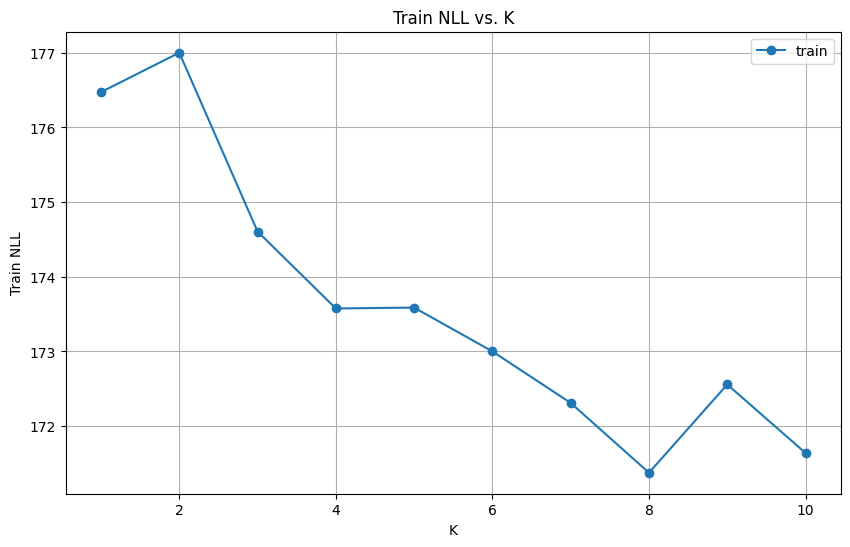

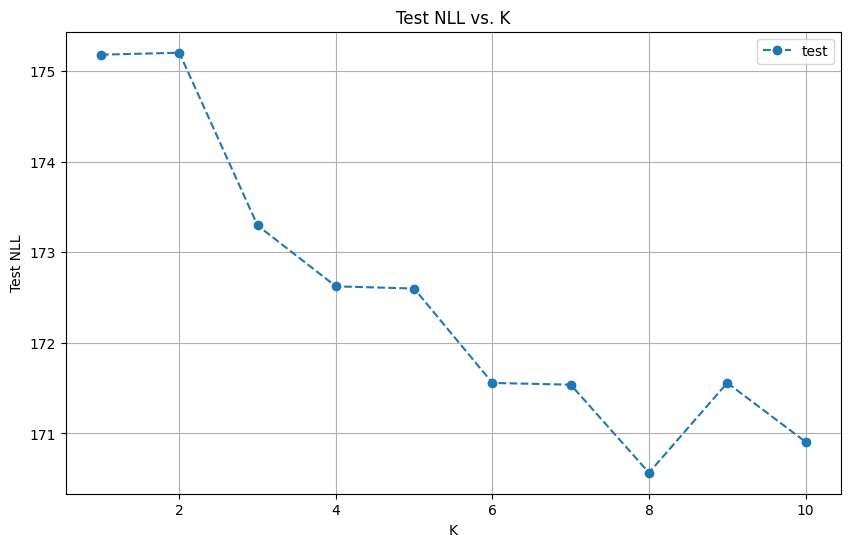

In [19]:
plot_test_nll_vs_k()

Finally, it is valuable to know, how long did it take you to finish this practical?

12h.